# 01-Business understanding
Objectives:
Deep understanding of the environmental impact of the agri-food industry, with a focus on climate change and global warming.
Provide the basis for policy development to reduce CO2 emissions from the agri-food sector.<br>
Data mining objectives: Examining the correlation between CO2 emissions from the agri-food sector and rising temperatures.<br>
Impacts are analyzed across countries based on aggregated data on emissions and temperature changes.<br>
Find the countries with the highest average annual temperature increases and analyze their overall environmental impact.

In [4]:
import findspark
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('spark').getOrCreate()

# 02-Data understanding

In [6]:
emission_df = spark.read.csv('Agrifood_co2_emission.csv', header=True)
population_df = spark.read.csv('Agrifood_co2_population.csv', header=True)

emission_df.show() # Display the first few rows of the CO2 emissions DataFrame

24/05/20 09:58:31 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----------+----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+
|       Area|Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|    IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emis

In [7]:
population_df.show() # Display the first few rows of the population DataFrame

+-----------+----+----------------+----------------+-----------------------+-------------------------+--------------+-------------------+
|       Area|Year|Rural population|Urban population|Total Population - Male|Total Population - Female|total_emission|Average Temperature|
+-----------+----+----------------+----------------+-----------------------+-------------------------+--------------+-------------------+
|Afghanistan|1990|         9655167|         2593947|              5348387.0|                5346409.0|   2198.963539|        0.536166667|
|Afghanistan|1991|        10230490|         2763167|              5372959.0|                5372208.0|   2323.876629|        0.020666667|
|Afghanistan|1992|        10995568|         2985663|              6028494.0|                6028939.0|   2356.304229|       -0.259583333|
|Afghanistan|1993|        11858090|         3237009|              7003641.0|                7000119.0|   2368.470529|        0.101916667|
|Afghanistan|1994|        12690115

In [69]:
from pyspark.sql.types import DoubleType

for col in emission_df.columns: # Iterate over all columns in the emission DataFrame
    if col != 'Area': # If the column is not 'Area', cast it to DoubleType
        emission_df = emission_df.withColumn(col, emission_df[col].cast(DoubleType()))

emission_df.printSchema() # Print the schema of the emission DataFrame to verify the changes

root
 |-- Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Savanna fires: double (nullable = false)
 |-- Forest fires: double (nullable = false)
 |-- Crop Residues: double (nullable = false)
 |-- Rice Cultivation: double (nullable = false)
 |-- Drained organic soils (CO2): double (nullable = false)
 |-- Pesticides Manufacturing: double (nullable = false)
 |-- Food Transport: double (nullable = false)
 |-- Forestland: double (nullable = false)
 |-- Net Forest conversion: double (nullable = false)
 |-- Food Household Consumption: double (nullable = false)
 |-- Food Retail: double (nullable = false)
 |-- On-farm Electricity Use: double (nullable = false)
 |-- Food Packaging: double (nullable = false)
 |-- Agrifood Systems Waste Disposal: double (nullable = false)
 |-- Food Processing: double (nullable = false)
 |-- Fertilizers Manufacturing: double (nullable = false)
 |-- IPPU: double (nullable = false)
 |-- Manure applied to Soils: double (nullable = false)
 |-- Ma

In [9]:
for col in population_df.columns: # Iterate over all columns in the population DataFrame
    if col != 'Area': # If the column is not 'Area', cast it to DoubleType
        population_df = population_df.withColumn(col, population_df[col].cast(DoubleType()))

population_df.printSchema() # Print the schema of the population DataFrame to verify the changes

root
 |-- Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- Rural population: double (nullable = true)
 |-- Urban population: double (nullable = true)
 |-- Total Population - Male: double (nullable = true)
 |-- Total Population - Female: double (nullable = true)
 |-- total_emission: double (nullable = true)
 |-- Average Temperature: double (nullable = true)



# Explore Data

In [10]:
from pyspark.sql.functions import format_number
emission_desc = emission_df.describe() # Generate descriptive statistics for the emission DataFrame
population_desc = population_df.describe() # Generate descriptive statistics for the population DataFrame
emission_desc.show() # Display the descriptive statistics of the emission DataFrame

+-------+-----------+------------------+------------------+-----------------+------------------+------------------+---------------------------+------------------------+------------------+-------------------+---------------------+--------------------------+-----------------+-----------------------+------------------+-------------------------------+------------------+-------------------------+------------------+-----------------------+----------------------+------------------+----------------------+-------------------------------+------------------+------------------+-------------------+
|summary|       Area|              Year|     Savanna fires|     Forest fires|     Crop Residues|  Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|    Food Transport|         Forestland|Net Forest conversion|Food Household Consumption|      Food Retail|On-farm Electricity Use|    Food Packaging|Agrifood Systems Waste Disposal|   Food Processing|Fertilizers Manufacturing|             

In [11]:
population_desc.show()

+-------+-----------+------------------+--------------------+-------------------+-----------------------+-------------------------+------------------+-------------------+
|summary|       Area|              Year|    Rural population|   Urban population|Total Population - Male|Total Population - Female|    total_emission|Average Temperature|
+-------+-----------+------------------+--------------------+-------------------+-----------------------+-------------------------+------------------+-------------------+
|  count|       6965|              6965|                6965|               6965|                   6965|                     6965|              6965|               6965|
|   mean|       null|2005.1249102656138|1.7857735393251974E7|1.693229697430007E7|    1.761962962555205E7|      1.732446929419813E7| 64091.24414763604| 0.8729890989691275|
| stddev|       null| 8.894665098397656| 8.901521375631623E7|6.574361960972756E7|    7.603993100724079E7|      7.251711353615724E7|228312.9579561

In [12]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.sql import functions as F

In [13]:
# Group the emission DataFrame by the 'Area' column
# Calculate the average of 'total_emission' and 'Average Temperature' for each area
result_df = (emission_df
            .groupBy("Area")
            .agg(F.mean("total_emission").alias("avg_total_emission"), 
                 F.mean("Average Temperature").alias("avg_Average_Temperature"))
           )

# Display the resulting DataFrame
result_df.show()

+--------------------+------------------+-----------------------+
|                Area|avg_total_emission|avg_Average_Temperature|
+--------------------+------------------+-----------------------+
|                Chad|39162.270102903225|     0.7723064516129031|
|        Ethiopia PDR| 62894.62087666666|     0.3387037036666667|
|Micronesia (Feder...| 5365.706396166668|    0.23188333326666666|
|            Anguilla|12337.998410967743|     0.6911290323870969|
|            Paraguay| 64001.78305741935|     0.5834865591612903|
|               Yemen|12664.442887516128|     0.8327671381290322|
|             Senegal|15999.267189354845|      1.173569892483871|
|          Cabo Verde|1792.0951166129034|      1.221443469451613|
|              Sweden| 14978.75349564516|      1.367548387064516|
|             Tokelau| 7255.679310838713|     0.7910204610322579|
|            Kiribati|  4290.79752116129|     0.5172469615161291|
|   Republic of Korea| 78375.29503225806|     0.8374166666129034|
|         

In [70]:
# Define a list of aggregation expressions
agg_exprs = [F.count(F.lit(1)).alias('count'), # Count the number of rows for each area
             F.mean('total_emission').alias('mean_total_emission'), # Calculate the mean of 'total_emission' for each area
             F.stddev('total_emission').alias('stddev_total_emission'),
             F.min('total_emission').alias('min_total_emission'),
             F.max('total_emission').alias('max_total_emission'),
             F.mean('Average Temperature').alias('mean_Average_Temperature'),
             F.stddev('Average Temperature').alias('stddev_Average_Temperature'),
             F.min('Average Temperature').alias('min_Average_Temperature'),
             F.max('Average Temperature').alias('max_Average_Temperature')]

# Group the emission DataFrame by the 'Area' column and apply the aggregation expressions
result_df = emission_df.groupBy("Area").agg(*agg_exprs)

# Display the resulting DataFrame without truncating the columns
result_df.show(truncate=False)

+--------------------------------+-----+-------------------+---------------------+------------------+------------------+------------------------+--------------------------+-----------------------+-----------------------+
|Area                            |count|mean_total_emission|stddev_total_emission|min_total_emission|max_total_emission|mean_Average_Temperature|stddev_Average_Temperature|min_Average_Temperature|max_Average_Temperature|
+--------------------------------+-----+-------------------+---------------------+------------------+------------------+------------------------+--------------------------+-----------------------+-----------------------+
|Chad                            |31   |39162.270102903225 |12093.626608465762   |20886.97741       |58155.73998       |0.7723064516129031      |0.39479642976715135       |-0.2335                |1.428                  |
|Ethiopia PDR                    |3    |62894.62087666666  |2628.966362075241    |61115.46849       |65914.32071    

# Visualisation

In [15]:
# Group the emission DataFrame by the 'Year' column
# Calculate the mean of 'Average Temperature' and 'total_emission' for each year
# Order the results by the 'Year' column
# Convert the resulting DataFrame to a Pandas DataFrame
temperature_emission_year = (emission_df
                            .groupBy("Year")
                            .agg(F.mean("Average Temperature").alias("Average Temperature"), 
                                 F.mean("total_emission").alias("total_emission"))
                            .orderBy("Year") 
                            .toPandas())

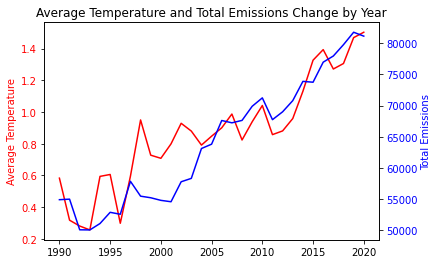

In [71]:
import matplotlib.pyplot as plt

# Create a figure and a set of subplots
fig, ax1 = plt.subplots()

# Plot the average temperature on the primary y-axis
ax1.plot(temperature_emission_year['Year'], temperature_emission_year['Average Temperature'], color='red', label='Average Temperature')
ax1.set_ylabel('Average Temperature', color='red') # Set the label for the primary y-axis
ax1.tick_params(axis='y', labelcolor='red') # Set the tick parameters for the primary y-axis

# Create a secondary y-axis sharing the same x-axis
ax2 = ax1.twinx()

# Plot the total emissions on the secondary y-axis
ax2.plot(temperature_emission_year['Year'], temperature_emission_year['total_emission'], color='blue', label='Total Emissions')
ax2.set_ylabel('Total Emissions', color='blue') # Set the label for the secondary y-axis
ax2.tick_params(axis='y', labelcolor='blue') # Set the tick parameters for the secondary y-axis

# Set the title and x-axis label for the plot
plt.title('Average Temperature and Total Emissions Change by Year')
plt.xlabel('Year')
plt.show()

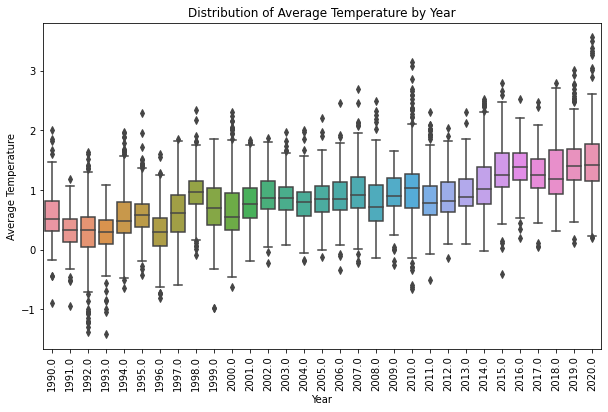

In [72]:
import seaborn as sns

# Convert the Spark DataFrame to a Pandas DataFrame for compatibility with seaborn
pandas_df = emission_df.toPandas()

# Create a figure with a specific size
plt.figure(figsize=(10,6))

# Create a box plot to show the distribution of average temperature by year
sns.boxplot(x='Year', y='Average Temperature', data=pandas_df)

# Set the title of the plot
plt.title('Distribution of Average Temperature by Year')

# Set the label for the x-axis
plt.xlabel('Year')

# Set the label for the y-axis
plt.ylabel('Average Temperature')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()

In [18]:
# Group the emission DataFrame by the 'Area' column
# Calculate the mean of 'Average Temperature' and 'total_emission' for each area
# Order the results by the 'Area' column
emission_temperature_area = (emission_df
                            .groupBy("Area")
                            .agg(F.mean("Average Temperature").alias("Average Temperature"), 
                                 F.mean("total_emission").alias("total_emission"))
                            .orderBy("Area")) 

# Convert the resulting Spark DataFrame to a Pandas DataFrame
pandas_df = emission_temperature_area.toPandas()

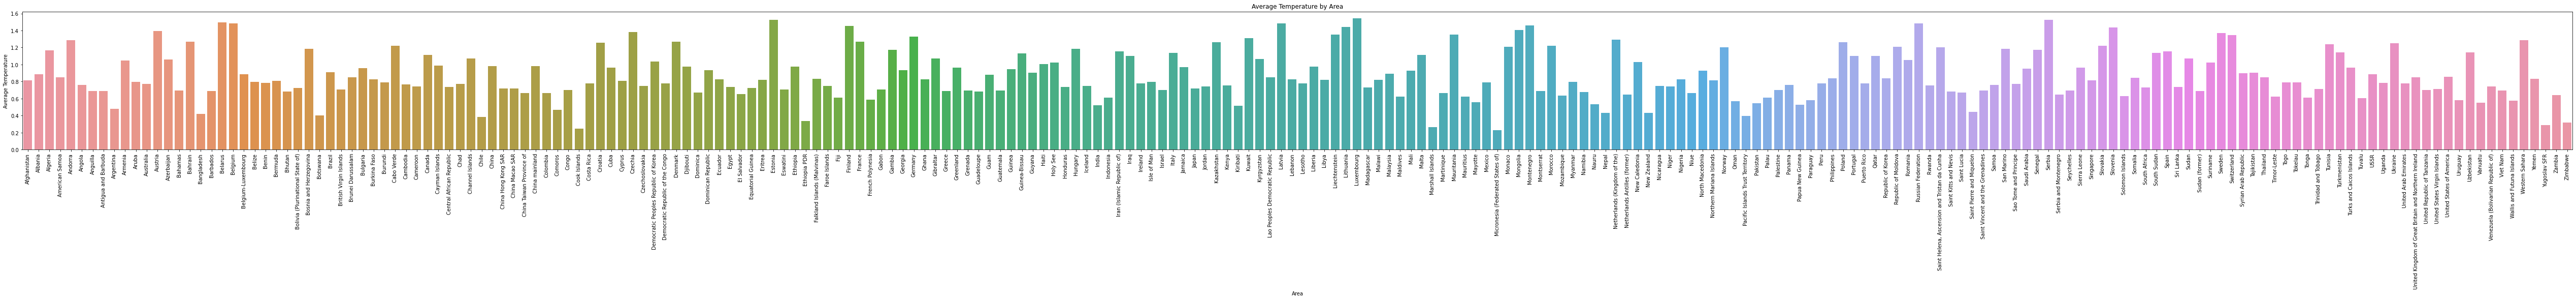

In [19]:
# Create a figure with a specific size (width: 90, height: 5)
plt.figure(figsize=(90,5))

# Create a bar plot to show the average temperature for each area
sns.barplot(x='Area', y='Average Temperature', data=pandas_df)

# Set the title of the plot
plt.title('Average Temperature by Area')

# Set the label for the x-axis
plt.xlabel('Area')

# Set the label for the y-axis
plt.ylabel('Average Temperature')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()

In [20]:
# Order the emission_temperature_area DataFrame by 'total_emission' in descending order
# Limit the result to the top 50 rows
emission_sorted = emission_temperature_area.orderBy(F.desc("total_emission")).limit(50)

# Convert the resulting Spark DataFrame to a Pandas DataFrame
pandas_sorted_df = emission_sorted.toPandas()

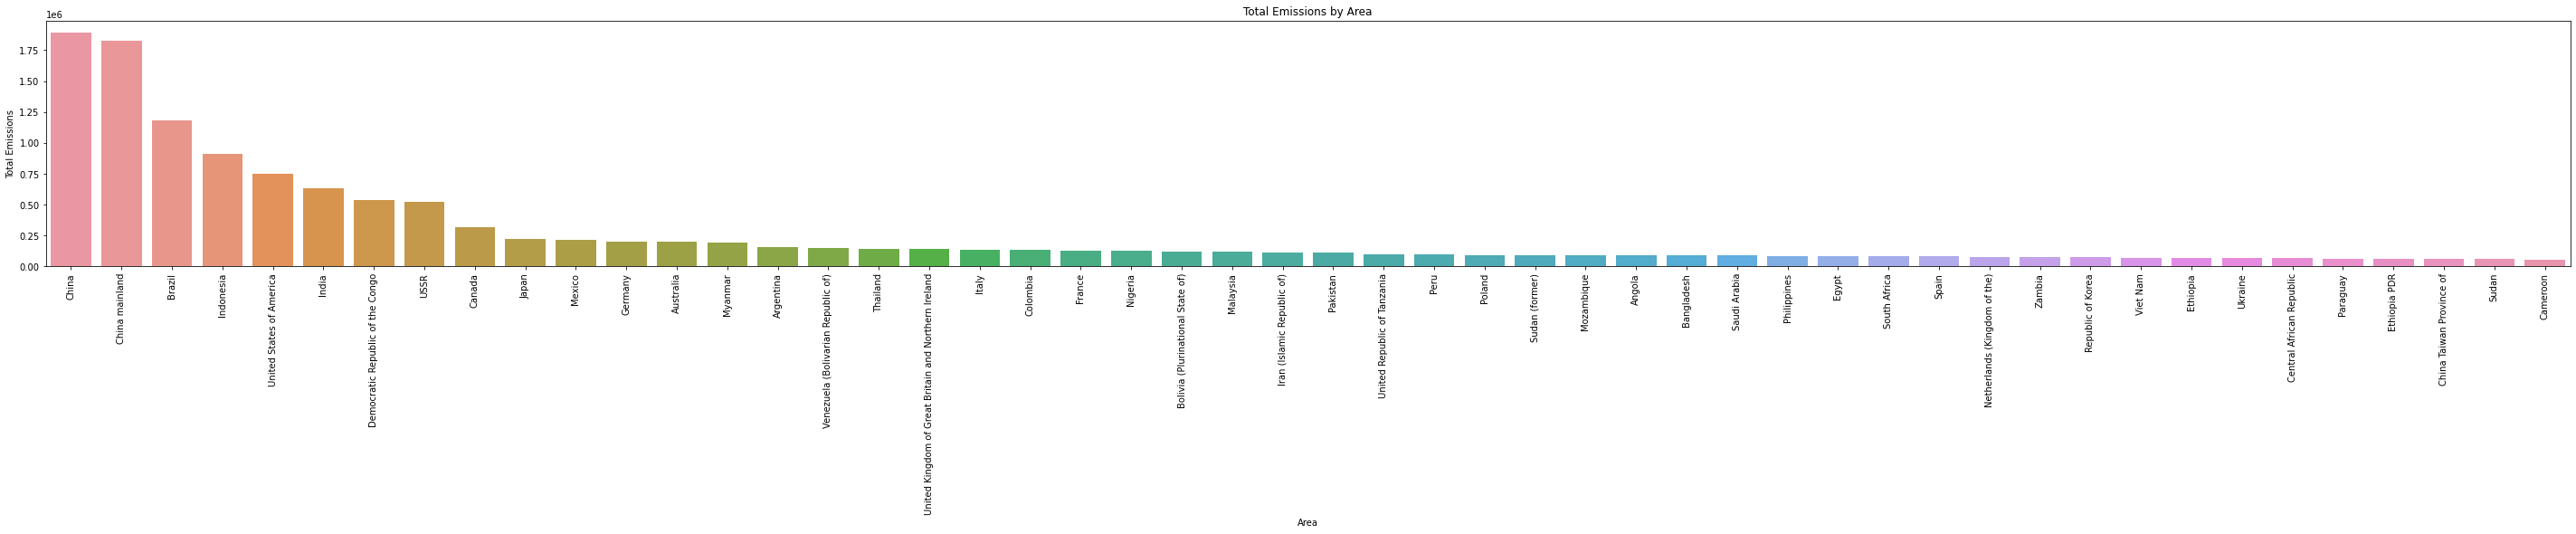

In [21]:
# Create a figure with a specific size (width: 50, height: 5)
plt.figure(figsize=(50,5))

# Create a bar plot to show the total emissions for each area in the sorted DataFrame
sns.barplot(x='Area', y='total_emission', data=pandas_sorted_df)

# Set the title of the plot
plt.title('Total Emissions by Area')
plt.xlabel('Area')
plt.ylabel('Total Emissions')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)

plt.show()

# Assessment data quality

In [22]:
# Calculate the number of missing (null) values for each column in the emission DataFrame
# Use a list comprehension to generate a list of column expressions
# For each column, sum up the number of null values and alias the result with the column name
missing_counts = emission_df.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in emission_df.columns])

missing_counts.show()

+----+----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+
|Area|Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emission|Average Temperatu

In [73]:
from pyspark.sql.functions import col, count, when

# Define a function to compute the lower and upper bounds for detecting outliers
def compute_bounds(df, col_name):
    # Compute the approximate 25th and 75th percentiles for the specified column
    bounds = df.approxQuantile(col_name, [0.25, 0.75], 0.01)
    Q1 = bounds[0]
    Q3 = bounds[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound


# Define numeric columns (excluding non-numeric types such as string, timestamp, and date)
numeric_cols = [col_name for col_name, col_type in emission_df.dtypes if col_type not in ['string', 'timestamp', 'date']]

# Initialize a dictionary to store outlier flags for each numeric column
outlier_flags = {}
for column in numeric_cols:
    lower, upper = compute_bounds(emission_df, column)
    outlier_flags[column] = (emission_df[column] < lower) | (emission_df[column] > upper)

# Construct the final DataFrame indicating outliers for each numeric column
outliers_df = emission_df.select(*[outlier_flags[col].alias(col) for col in numeric_cols])

# Show the outlier DataFrame
outliers_df.show()

+-----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+-----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+----------------------+
| Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing| IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emission|

# 03-Data preparation
Data clean

In [26]:
# Define the list of columns that need imputation
cols_to_impute = ['Savanna fires', 'Forest fires', 'Crop Residues',
                  'Rice Cultivation', 'Drained organic soils (CO2)',
                  'Pesticides Manufacturing', 'Food Transport', 'Forestland',
                  'Net Forest conversion', 'Food Household Consumption', 
                  'Food Retail', 'On-farm Electricity Use', 'Food Packaging',
                  'Agrifood Systems Waste Disposal', 'Food Processing',
                  'Fertilizers Manufacturing', 'IPPU', 
                  'Manure applied to Soils', 'Manure left on Pasture', 
                  'Manure Management', 'Fires in organic soils',
                  'Fires in humid tropical forests', 'On-farm energy use']

from pyspark.ml.feature import Imputer
from pyspark.sql.functions import lit

In [74]:
# Iterate over the list of columns that need imputation
for col_name in cols_to_impute:
    # Calculate the median value for the current column
    median_value = emission_df.approxQuantile(col_name, [0.5], 0.1)[0]
    # Fill missing values in the current column with the median value
    emission_df = emission_df.na.fill(median_value, [col_name])

# Calculate the number of missing (null) values for each column in the emission DataFrame
# Use a list comprehension to generate a list of column expressions
# For each column, sum up the number of null values and alias the result with the column name
missing_counts = emission_df.select([F.sum(F.when(F.col(c).isNull(), 1).otherwise(0)).alias(c) for c in emission_df.columns])
missing_counts.show()

+----+----+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+----------------------+
|Area|Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On-farm energy use|total_emi

In [28]:
from functools import reduce

# Define the list of columns to be summed for the total emission calculation
cols_to_sum = ['Savanna fires', 'Forest fires', 'Crop Residues',
               'Rice Cultivation', 'Drained organic soils (CO2)',
               'Pesticides Manufacturing', 'Food Transport', 'Forestland',
               'Net Forest conversion', 'Food Household Consumption', 
               'Food Retail', 'On-farm Electricity Use', 'Food Packaging',
               'Agrifood Systems Waste Disposal', 'Food Processing',
               'Fertilizers Manufacturing', 'IPPU', 
               'Manure applied to Soils', 'Manure left on Pasture', 
               'Manure Management', 'Fires in organic soils',
               'Fires in humid tropical forests', 'On-farm energy use']

# Use the reduce function to sum all the specified columns for total emission calculation
total_emission = reduce(lambda a, b: a + b, (F.col(c) for c in cols_to_sum))

# Add a new column 'Updated_total_emission' to the DataFrame with the calculated total emissions
emission_df = emission_df.withColumn('Updated_total_emission', total_emission)

In [29]:
emission_df.show()

+-----------+------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+----------------------+
|       Area|  Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|    IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropical forests|On

In [30]:
from pyspark.sql.functions import round

# Generate descriptive statistics for the emission DataFrame
summary = emission_df.describe()

# Iterate over all columns in the summary DataFrame
for col_name in summary.columns:
    if col_name != 'summary':
        summary = summary.withColumn(col_name, round(summary[col_name], 2))

summary.show()

+-------+------+-------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+--------------+-------------------+----------------------+
|summary|  Area|   Year|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|      IPPU|Manure applied to Soils|Manure left on Pasture|Manure Management|Fires in organic soils|Fires in humid tropica

In [31]:
# Join the emission DataFrame with the population DataFrame on the columns 'Area', 'Year', 'total_emission', and 'Average Temperature'
agrifood_emission_df = emission_df.join(population_df, ['Area', 'Year', 'total_emission', 'Average Temperature'])
agrifood_emission_df.show()

+-----------+------+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+
|       Area|  Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing|    IPPU|Man

In [32]:
# Add a new column 'Total_population' to the DataFrame by summing 'Total Population - Female' and 'Total Population - Male'
agrifood_emission_df = agrifood_emission_df.withColumn('Total_population', 
                                                       agrifood_emission_df['Total Population - Female'] + agrifood_emission_df['Total Population - Male'])

# Add a new column 'Emission_per_capita' to the DataFrame by dividing 'Updated_total_emission' by 'Total_population'
agrifood_emission_df = agrifood_emission_df.withColumn('Emission_per_capita', 
                                                       agrifood_emission_df['Updated_total_emission'] / agrifood_emission_df['Total_population'])

agrifood_emission_df.show()

+-----------+------+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+--------+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+----------------+--------------------+
|       Area|  Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|

In [33]:
from pyspark.sql.functions import isnan, when, count, col

# Select columns and count the number of missing (null or NaN) values for each column in the agrifood_emission_df DataFrame
# Use a list comprehension to generate a list of column expressions
# For each column, count the number of null or NaN values and alias the result with the column name
agrifood_emission_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in agrifood_emission_df.columns]).show()

+----+----+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+----------------+-------------------+
|Area|Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturi

In [34]:
# Define numeric columns by excluding non-numeric types such as 'string'
numeric_cols = [col_name for col_name, col_type in agrifood_emission_df.dtypes if col_type != 'string']

# Initialize a dictionary to store outlier flags for each numeric column
outlier_flags = {}
for column in numeric_cols:
    lower, upper = compute_bounds(agrifood_emission_df, column)
    outlier_flags[column] = (agrifood_emission_df[column] < lower) | (agrifood_emission_df[column] > upper)

outliers_df = agrifood_emission_df.select(*[outlier_flags[col].alias(col) for col in numeric_cols])

outliers_df.show()

+-----+--------------+-------------------+-------------+------------+-------------+----------------+---------------------------+------------------------+--------------+----------+---------------------+--------------------------+-----------+-----------------------+--------------+-------------------------------+---------------+-------------------------+-----+-----------------------+----------------------+-----------------+----------------------+-------------------------------+------------------+----------------------+----------------+----------------+-----------------------+-------------------------+----------------+-------------------+
| Year|total_emission|Average Temperature|Savanna fires|Forest fires|Crop Residues|Rice Cultivation|Drained organic soils (CO2)|Pesticides Manufacturing|Food Transport|Forestland|Net Forest conversion|Food Household Consumption|Food Retail|On-farm Electricity Use|Food Packaging|Agrifood Systems Waste Disposal|Food Processing|Fertilizers Manufacturing| IPP

# 04-Data transformation

In [35]:
import matplotlib.pyplot as plt

# Define the columns to plot
cols = ['Savanna fires', 'Forest fires', 'Crop Residues',
       'Rice Cultivation', 'Drained organic soils (CO2)',
       'Pesticides Manufacturing', 'Food Transport', 'Forestland',
       'Net Forest conversion', 'Food Household Consumption', 'Food Retail',
       'On-farm Electricity Use', 'Food Packaging',
       'Agrifood Systems Waste Disposal', 'Food Processing',
       'Fertilizers Manufacturing', 'IPPU', 'Manure applied to Soils',
       'Manure left on Pasture', 'Manure Management', 'Fires in organic soils',
       'Fires in humid tropical forests', 'On-farm energy use',
       'total_emission', 'Average Temperature', 'Updated_total_emission',
       'Rural population', 'Urban population', 'Total Population - Male',
       'Total Population - Female', 'Total_population', 'Emission_per_capita']

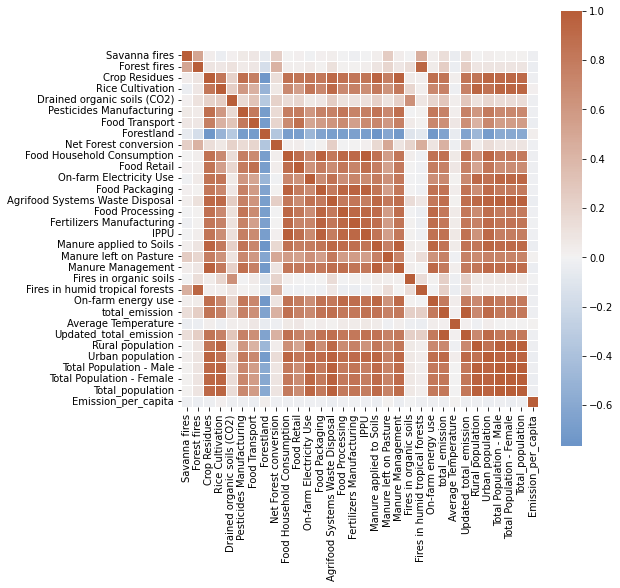

In [36]:
# Convert the selected columns of the agrifood_emission_df DataFrame to a Pandas DataFrame
pandas_df = agrifood_emission_df.select(cols).toPandas()

# Compute the correlation matrix for the Pandas DataFrame
corr = pandas_df.corr()

# Create a figure with a specific size (width: 8, height: 8)
plt.figure(figsize=(8, 8))

# Define a colormap using seaborn's diverging_palette
cmap = sns.diverging_palette(250, 25, as_cmap=True)

# Create a heatmap to show the correlation matrix
sns.heatmap(corr, cmap=cmap, vmax=None, center=0, square=True, annot=False, linewidths=.5)

plt.show()

In [37]:
agrifood_emission_df.printSchema()

root
 |-- Area: string (nullable = true)
 |-- Year: double (nullable = true)
 |-- total_emission: double (nullable = true)
 |-- Average Temperature: double (nullable = true)
 |-- Savanna fires: double (nullable = false)
 |-- Forest fires: double (nullable = false)
 |-- Crop Residues: double (nullable = false)
 |-- Rice Cultivation: double (nullable = false)
 |-- Drained organic soils (CO2): double (nullable = false)
 |-- Pesticides Manufacturing: double (nullable = false)
 |-- Food Transport: double (nullable = false)
 |-- Forestland: double (nullable = false)
 |-- Net Forest conversion: double (nullable = false)
 |-- Food Household Consumption: double (nullable = false)
 |-- Food Retail: double (nullable = false)
 |-- On-farm Electricity Use: double (nullable = false)
 |-- Food Packaging: double (nullable = false)
 |-- Agrifood Systems Waste Disposal: double (nullable = false)
 |-- Food Processing: double (nullable = false)
 |-- Fertilizers Manufacturing: double (nullable = false)
 |-

In [38]:
corr_avg_temp = corr['Average Temperature'].drop('Average Temperature')  # Drop the self-correlation
sorted_corr = corr_avg_temp.abs().sort_values(ascending=False)
print(sorted_corr)

Food Transport                     0.075724
Food Retail                        0.073404
IPPU                               0.062357
Food Household Consumption         0.055577
Food Processing                    0.053083
Forestland                         0.052053
Savanna fires                      0.046772
Manure applied to Soils            0.042311
Fertilizers Manufacturing          0.041462
Food Packaging                     0.040767
Forest fires                       0.039374
On-farm energy use                 0.039013
Fires in humid tropical forests    0.036910
Urban population                   0.036263
Manure Management                  0.032742
Drained organic soils (CO2)        0.029030
Pesticides Manufacturing           0.027960
Net Forest conversion              0.027359
Crop Residues                      0.025701
Fires in organic soils             0.023731
Rice Cultivation                   0.022532
Rural population                   0.019764
total_emission                  

In [39]:
# Drop the 'total_emission' column from the sorted correlation DataFrame
sorted_corr = sorted_corr.drop('total_emission')

# Select the top 25 features based on correlation
features = sorted_corr.head(25)

print(features)

Food Transport                     0.075724
Food Retail                        0.073404
IPPU                               0.062357
Food Household Consumption         0.055577
Food Processing                    0.053083
Forestland                         0.052053
Savanna fires                      0.046772
Manure applied to Soils            0.042311
Fertilizers Manufacturing          0.041462
Food Packaging                     0.040767
Forest fires                       0.039374
On-farm energy use                 0.039013
Fires in humid tropical forests    0.036910
Urban population                   0.036263
Manure Management                  0.032742
Drained organic soils (CO2)        0.029030
Pesticides Manufacturing           0.027960
Net Forest conversion              0.027359
Crop Residues                      0.025701
Fires in organic soils             0.023731
Rice Cultivation                   0.022532
Rural population                   0.019764
Updated_total_emission          

In [40]:
feature_names = features.index.tolist()
print(feature_names)

['Food Transport', 'Food Retail', 'IPPU', 'Food Household Consumption', 'Food Processing', 'Forestland', 'Savanna fires', 'Manure applied to Soils', 'Fertilizers Manufacturing', 'Food Packaging', 'Forest fires', 'On-farm energy use', 'Fires in humid tropical forests', 'Urban population', 'Manure Management', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Net Forest conversion', 'Crop Residues', 'Fires in organic soils', 'Rice Cultivation', 'Rural population', 'Updated_total_emission', 'Manure left on Pasture', 'Emission_per_capita']


In [41]:
from pyspark.sql.functions import mean, stddev, col

# Define the list of columns to be scaled (this should match the features you identified)
columns_to_scale = feature_names

# Select the specified columns from the agrifood_emission_df DataFrame
agrifood_emission_df2 = agrifood_emission_df.select('Area', 'Year', 'Average Temperature',
                                                    'Food Transport', 'Food Retail', 'IPPU', 'Food Household Consumption', 'Food Processing', 'Forestland', 'Savanna fires', 'Manure applied to Soils', 'Fertilizers Manufacturing', 'Food Packaging', 'Forest fires', 'On-farm energy use', 'Fires in humid tropical forests', 'Urban population', 'Manure Management', 'Drained organic soils (CO2)', 'Pesticides Manufacturing', 'Net Forest conversion', 'Crop Residues', 'Fires in organic soils', 'Rice Cultivation', 'Rural population', 'Updated_total_emission', 'Manure left on Pasture', 'Emission_per_capita')

agrifood_emission_df2.show()

+-----------+------+-------------------+--------------+-----------+--------+--------------------------+---------------+----------+-------------+-----------------------+-------------------------+--------------+------------+------------------+-------------------------------+----------------+-----------------+---------------------------+------------------------+---------------------+-------------+----------------------+----------------+----------------+----------------------+----------------------+--------------------+
|       Area|  Year|Average Temperature|Food Transport|Food Retail|    IPPU|Food Household Consumption|Food Processing|Forestland|Savanna fires|Manure applied to Soils|Fertilizers Manufacturing|Food Packaging|Forest fires|On-farm energy use|Fires in humid tropical forests|Urban population|Manure Management|Drained organic soils (CO2)|Pesticides Manufacturing|Net Forest conversion|Crop Residues|Fires in organic soils|Rice Cultivation|Rural population|Updated_total_emission|M

In [42]:
from pyspark.ml.feature import VectorAssembler

# Define the list of feature columns by removing 'Area', 'Year', and 'Average Temperature' from the columns of agrifood_emission_df2
feature_columns = agrifood_emission_df2.columns  
feature_columns.remove('Area')  
feature_columns.remove('Year')  
feature_columns.remove('Average Temperature')

# Create a VectorAssembler instance with the input columns as the feature columns and the output column as 'features'
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Transform the DataFrame by assembling the feature columns into a single vector column
feature_vector = assembler.transform(agrifood_emission_df2)

In [43]:
from pyspark.ml.feature import StandardScaler

# Create a StandardScaler instance with the input column as 'features' and the output column as 'scaledFeatures'
# Set withStd to True to scale the data to unit standard deviation
# Set withMean to False to keep the mean at its original value
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(feature_vector)
agrifood_dm_df = scalerModel.transform(feature_vector)

In [44]:
agrifood_dm_df.show()

+-----------+------+-------------------+--------------+-----------+--------+--------------------------+---------------+----------+-------------+-----------------------+-------------------------+--------------+------------+------------------+-------------------------------+----------------+-----------------+---------------------------+------------------------+---------------------+-------------+----------------------+----------------+----------------+----------------------+----------------------+--------------------+--------------------+--------------------+
|       Area|  Year|Average Temperature|Food Transport|Food Retail|    IPPU|Food Household Consumption|Food Processing|Forestland|Savanna fires|Manure applied to Soils|Fertilizers Manufacturing|Food Packaging|Forest fires|On-farm energy use|Fires in humid tropical forests|Urban population|Manure Management|Drained organic soils (CO2)|Pesticides Manufacturing|Net Forest conversion|Crop Residues|Fires in organic soils|Rice Cultivation

# 05-Data mining methods selection
Examine the correlation between CO2 emissions from the agri-food sector and rising temperatures:<br>

Selection regression analysis was used to investigate the link between CO2 emissions and temperature increase. This approach helps to assess the magnitude and direction of the associations between the above variables.<br>
<br>
Impacts are analyzed across countries based on aggregated data on emissions and temperature changes:<br>

Clustering techniques are used to classify countries based on emissions and temperature change data. This approach enables the identification of patterns and trends in data sets, facilitating a comprehensive understanding of each country's contribution to emissions and temperature fluctuations.<br>
<br>
Identify the countries with the highest temperature rises and analyze their overall environmental impact:<br>

Use descriptive statistics to identify the countries with the largest per capita emissions. Once these countries are identified, use decision tree analysis to gain insight into their contribution to overall environmental impact.

# 06-Data mining algorithms selection

In [45]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator, RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

# 07-Data mining
Regression

In [46]:
train_data, test_data = feature_vector.randomSplit([0.8, 0.2], seed=42)

print(f"Training Dataset Count: {train_data.count()}")
print(f"Test Dataset Count: {test_data.count()}")

Training Dataset Count: 5637
Test Dataset Count: 1328


In [47]:
# Initialize and train the model
rf = RandomForestRegressor(featuresCol="features", labelCol="Average Temperature")
model = rf.fit(train_data)

# Extract feature importances
importances = model.featureImportances

# Print feature importances
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")

Food Transport: 0.05940842656133941
Food Retail: 0.16980414925917947
IPPU: 0.08203029776455752
Food Household Consumption: 0.03868281330616731
Food Processing: 0.012204265652240701
Forestland: 0.040592409833265126
Savanna fires: 0.015111006316082717
Manure applied to Soils: 0.03944791566851119
Fertilizers Manufacturing: 0.017674882585815795
Food Packaging: 0.020595885978570556
Forest fires: 0.04461079830252489
On-farm energy use: 0.03141525363829496
Fires in humid tropical forests: 0.06885499440380942
Urban population: 0.017299664675785534
Manure Management: 0.01186193273163907
Drained organic soils (CO2): 0.03344917116725811
Pesticides Manufacturing: 0.01642242369528938
Net Forest conversion: 0.03159901949208057
Crop Residues: 0.009298066279903495
Fires in organic soils: 0.008858823477758349
Rice Cultivation: 0.05226607115066874
Rural population: 0.032266695527010066
Updated_total_emission: 0.017470981884529672
Manure left on Pasture: 0.09539765736980377
Emission_per_capita: 0.0333763

In [48]:
# Get the feature importances from the model and convert them to an array
importances = model.featureImportances.toArray()

# Pair the feature names with their respective importances
paired = list(zip(feature_names, importances))

# Sort the features by importance in descending order
sorted_features = sorted(paired, key=lambda x: x[1], reverse=True)

# Print the sorted features with their importances
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Food Retail: 0.16980414925917947
Manure left on Pasture: 0.09539765736980377
IPPU: 0.08203029776455752
Fires in humid tropical forests: 0.06885499440380942
Food Transport: 0.05940842656133941
Rice Cultivation: 0.05226607115066874
Forest fires: 0.04461079830252489
Forestland: 0.040592409833265126
Manure applied to Soils: 0.03944791566851119
Food Household Consumption: 0.03868281330616731
Drained organic soils (CO2): 0.03344917116725811
Emission_per_capita: 0.03337639327791433
Rural population: 0.032266695527010066
Net Forest conversion: 0.03159901949208057
On-farm energy use: 0.03141525363829496
Food Packaging: 0.020595885978570556
Fertilizers Manufacturing: 0.017674882585815795
Updated_total_emission: 0.017470981884529672
Urban population: 0.017299664675785534
Pesticides Manufacturing: 0.01642242369528938
Savanna fires: 0.015111006316082717
Food Processing: 0.012204265652240701
Manure Management: 0.01186193273163907
Crop Residues: 0.009298066279903495
Fires in organic soils: 0.00885882

In [49]:
# Transform the test data using the trained model to get predictions
test_predictions = model.transform(test_data)

# Create a RegressionEvaluator instance to evaluate the model's performance
# Specify the label column, prediction column, and the evaluation metric (root mean squared error)
evaluator = RegressionEvaluator(labelCol="Average Temperature", predictionCol="prediction", metricName="rmse")

# Evaluate the predictions and calculate the root mean squared error (RMSE) on the test data
rmse = evaluator.evaluate(test_predictions)
print(f"Root Mean Squared Error (RMSE) on test data: {rmse}")

Root Mean Squared Error (RMSE) on test data: 0.5018292355744848


# Clustering

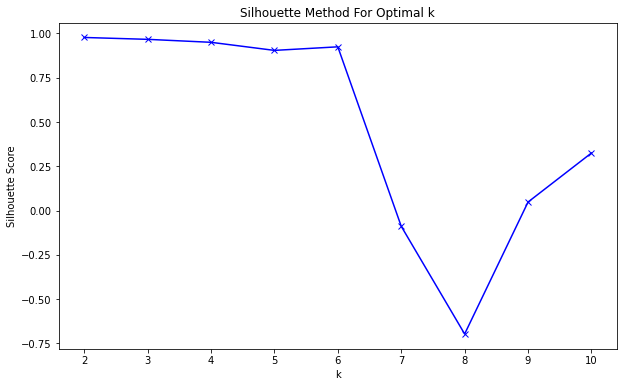

In [50]:
# Define the range of k values to evaluate
k_range = range(2, 11)

# Initialize an empty list to store silhouette scores
silhouette_list = []

# Loop through the range of k values
for k in k_range:
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    model = kmeans.fit(agrifood_dm_df)
    predictions = model.transform(agrifood_dm_df)

    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silhouette_list.append(silhouette)

# Plot the silhouette scores for each k value
plt.figure(figsize=(10,6))
plt.plot(k_range, silhouette_list, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method For Optimal k')
plt.show()

In [75]:
# Apply KMeans clustering with k=4
# Create a KMeans instance with k=4, a fixed random seed, and the features column set to "scaledFeatures"
kmeans = KMeans().setK(4).setSeed(1).setFeaturesCol("scaledFeatures")

# Fit the KMeans model on the scaled features DataFrame
model = kmeans.fit(agrifood_dm_df)

# Transform the DataFrame to get cluster predictions
predictions = model.transform(agrifood_dm_df)

In [52]:
# Get the cluster centers from the KMeans model
centers = model.clusterCenters()

# Print the cluster centers
print("Cluster Centers: ")
for index, center in enumerate(centers):
    print(f"Cluster {index}: {center}")

Cluster Centers: 
Cluster 0: [ 0.24013637  0.13493625  0.06729975  0.0760308   0.08901841 -0.10251315
  0.21900354  0.13633069  0.15525106  0.04512808  0.22215241  0.10389359
  0.18451477  0.13075592  0.13309576  0.20180314  0.11112109  0.10949915
  0.10601614  0.04684556  0.13143806  0.08278887  0.1597646   0.25626289
  0.12066012]
Cluster 1: [ 5.72561399e+00  9.17729055e+00  1.27021114e+01  1.23534396e+01
  1.16627595e+01 -6.81610099e+00  6.27320098e-02  9.43150958e+00
  1.22303265e+01  1.31304145e+01  1.79158060e-01  9.73302694e+00
  3.87323032e-04  1.09998558e+01  8.62350581e+00  2.43051336e-01
  8.15191267e+00  0.00000000e+00  8.87403679e+00  0.00000000e+00
  8.36225251e+00  7.47530854e+00  1.08717379e+01  6.09797212e+00
  8.40334280e-04]
Cluster 2: [ 2.65304874e+00  2.49702968e+00  2.33962302e+00  2.73084827e+00
  3.34058148e+00 -2.95480365e+00  1.11059629e-01  6.19056996e+00
  4.20988278e+00  2.59931903e+00  8.00997533e-01  5.03544182e+00
  1.97927782e-01  5.65884889e+00  6.4381

In [53]:
# Group the predictions by the 'prediction' column (which indicates the cluster assignment)
# Count the number of data points in each cluster
cluster_assignments = predictions.groupBy("prediction").count().orderBy("prediction")
cluster_assignments.show()

+----------+-----+
|prediction|count|
+----------+-----+
|         0| 6806|
|         1|   34|
|         2|   61|
|         3|   64|
+----------+-----+



# 08-Interpretation
Regression

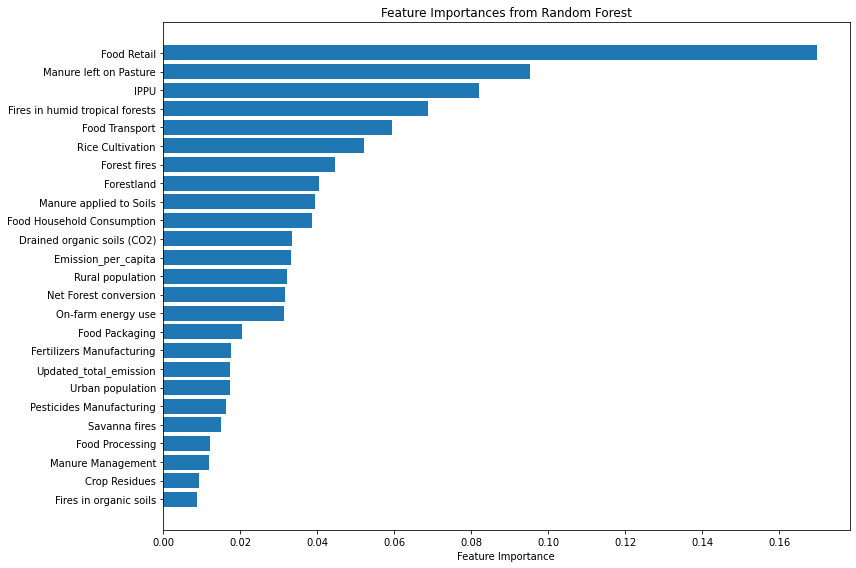

In [54]:
# Unzip the sorted features and their importance values into separate lists
features, importance_values = zip(*sorted_features)

# Create a figure with a specific size (width: 12, height: 8)
plt.figure(figsize=(12, 8))
plt.barh(features, importance_values, align='center')  
plt.xlabel('Feature Importance')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  
plt.tight_layout()

Clustering

In [56]:
# Select the specified columns from the predictions DataFrame and collect them as a list of rows
selected_data = predictions.select("Food Retail", "Average Temperature", "emission_per_capita", "Updated_total_emission", "prediction").collect()
food_retail_values, avg_temp_values, emission_per_capita_values, total_emission_values, cluster_predictions = zip(*[(x[0], x[1], x[2], x[3], x[4]) for x in selected_data])

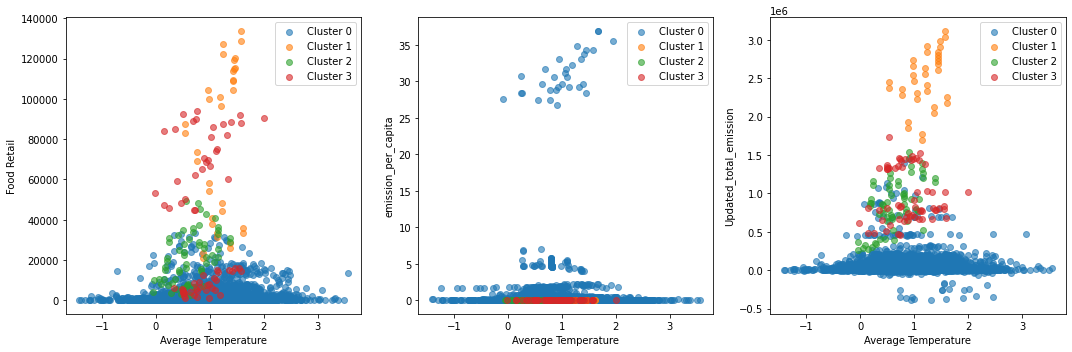

In [57]:
# Create a figure with a specific size (width: 15, height: 5)
plt.figure(figsize=(15, 5))

# Subplot 1: Food Retail vs. Average Temperature
plt.subplot(1, 3, 1)
for i in range(4):  # Loop through each cluster
    y_vals = [food_retail_values[j] for j in range(len(food_retail_values)) if cluster_predictions[j] == i]
    x_vals = [avg_temp_values[j] for j in range(len(avg_temp_values)) if cluster_predictions[j] == i]
    plt.scatter(x_vals, y_vals, label=f'Cluster {i}', alpha=0.6)
plt.xlabel('Average Temperature')
plt.ylabel('Food Retail')
plt.legend()

# Subplot 2: Average Temperature vs. Emission_per_capita
plt.subplot(1, 3, 2)
for i in range(4):  # Loop through each cluster
    x_vals = [avg_temp_values[j] for j in range(len(avg_temp_values)) if cluster_predictions[j] == i]
    y_vals = [emission_per_capita_values[j] for j in range(len(emission_per_capita_values)) if cluster_predictions[j] == i]
    plt.scatter(x_vals, y_vals, label=f'Cluster {i}', alpha=0.6)
plt.xlabel('Average Temperature')
plt.ylabel('emission_per_capita')
plt.legend()

# Subplot 3: Average Temperature vs. Updated_total_emission
plt.subplot(1, 3, 3)
for i in range(4): # Loop through each cluster
    x_vals = [avg_temp_values[j] for j in range(len(avg_temp_values)) if cluster_predictions[j] == i]
    y_vals = [total_emission_values[j] for j in range(len(total_emission_values)) if cluster_predictions[j] == i]
    plt.scatter(x_vals, y_vals, label=f'Cluster {i}', alpha=0.6)
plt.xlabel('Average Temperature')
plt.ylabel('Updated_total_emission')
plt.legend()

# Adjust the layout to make it more compact and visually appealing
plt.tight_layout()
plt.show()

Descriptive statistic

In [77]:
# Filter the DataFrame to include only rows where the 'Year' is 2020
agrifood_2020 = agrifood_emission_df.filter(agrifood_emission_df['Year'] == 2020)

from pyspark.sql import functions as F

# Order the DataFrame by 'Average Temperature' in descending order and limit the result to the top 30 rows
temperature_2020 = agrifood_2020.orderBy(F.desc('Average Temperature')).limit(30)

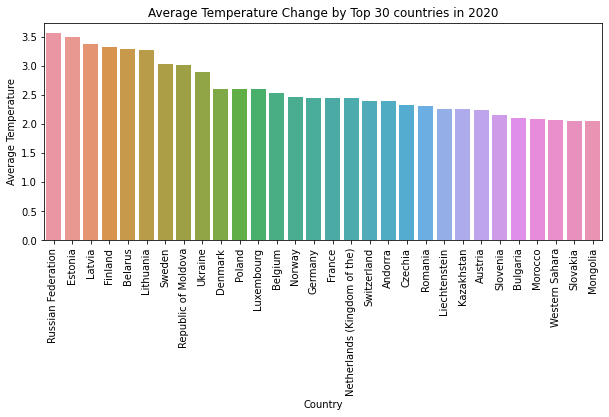

In [59]:
import seaborn as sns

# Convert the selected columns of the temperature_2020 DataFrame to a Pandas DataFrame
plot_data = temperature_2020.select('Area', 'Average Temperature').toPandas()

# Create a figure with a specific size (width: 10, height: 4)
plt.figure(figsize=(10,4))

# Create a bar plot to show the average temperature for the top 30 countries in 2020
sns.barplot(x='Area', y='Average Temperature', data=plot_data)
plt.title('Average Temperature Change by Top 30 countries in 2020')
plt.xlabel('Country')
plt.ylabel('Average Temperature')
plt.xticks(rotation=90)
plt.show()

In [60]:
emission_2020 = agrifood_2020.orderBy(F.desc('Updated_total_emission')).limit(30)

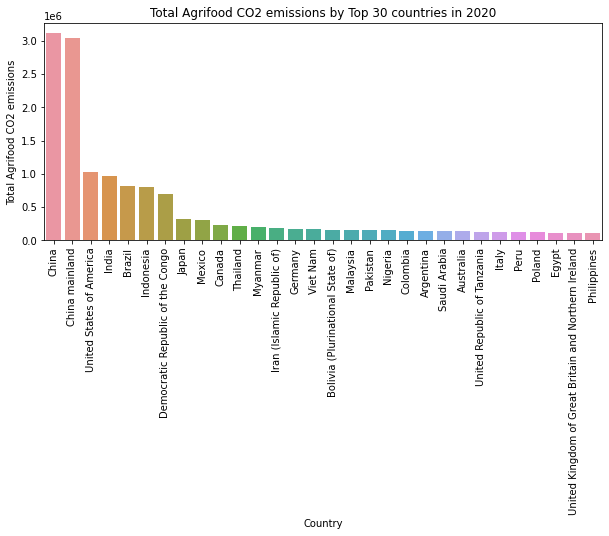

In [61]:
# Convert the selected columns of the emission_2020 DataFrame to a Pandas DataFrame
plot_data = emission_2020.select('Area', 'Updated_total_emission').toPandas()

# Create a figure with a specific size (width: 10, height: 4)
plt.figure(figsize=(10,4))
sns.barplot(x='Area', y='Updated_total_emission', data=plot_data)
plt.title('Total Agrifood CO2 emissions by Top 30 countries in 2020')
plt.xlabel('Country')
plt.ylabel('Total Agrifood CO2 emissions')
plt.xticks(rotation=90)
plt.show()

In [62]:
# Order the DataFrame by 'Emission_per_capita' in descending order and limit the result to the top 30 rows
emission_per_capita = agrifood_2020.orderBy(F.desc('Emission_per_capita')).limit(30)

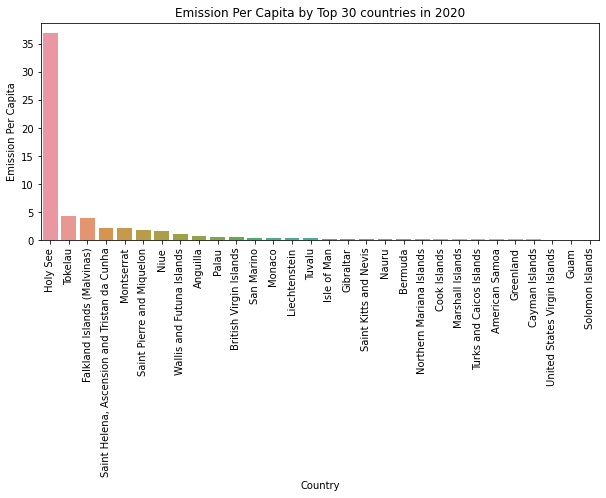

In [63]:
# Convert the selected columns of the emission_per_capita DataFrame to a Pandas DataFrame
plot_data = emission_per_capita.select('Area', 'Emission_per_capita').toPandas()

# Create a figure with a specific size (width: 10, height: 4)
plt.figure(figsize=(10,4))

# Create a bar plot to show the emission per capita for the top 30 countries in 2020
sns.barplot(x='Area', y='Emission_per_capita', data=plot_data)
plt.title('Emission Per Capita by Top 30 countries in 2020')
plt.xlabel('Country')
plt.ylabel('Emission Per Capita')
plt.xticks(rotation=90)
plt.show()

In [64]:
# Filter the DataFrame to include only rows where the 'Area' is 'Russian Federation' and select relevant columns
russian_federation_data = agrifood_2020.filter(agrifood_2020['Area'] == 'Russian Federation') \
                                       .select('Area', 'Average Temperature', 'Updated_total_emission', 'Emission_per_capita')

russian_federation_data.show()

+------------------+-------------------+----------------------+--------------------+
|              Area|Average Temperature|Updated_total_emission| Emission_per_capita|
+------------------+-------------------+----------------------+--------------------+
|Russian Federation|        3.558083333|    34468.790900000015|2.367080303794615...|
+------------------+-------------------+----------------------+--------------------+



In [65]:
# Filter the DataFrame to include only rows where the 'Area' is 'China' and select relevant columns
china_data = agrifood_2020.filter(agrifood_2020['Area'] == 'China') \
                                       .select('Area', 'Average Temperature', 'Updated_total_emission', 'Emission_per_capita')

china_data.show()

+-----+-------------------+----------------------+--------------------+
| Area|Average Temperature|Updated_total_emission| Emission_per_capita|
+-----+-------------------+----------------------+--------------------+
|China|              1.574|          3115113.7488|0.002138137716844574|
+-----+-------------------+----------------------+--------------------+



In [66]:
# Set up the parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20, 30])  # Number of trees
             .addGrid(rf.maxDepth, [5, 10, 20])   # Maximum depth of each tree
             .build())

# Set up 5-fold cross validation
crossval = CrossValidator(estimator=rf,
                          estimatorParamMaps=paramGrid,
                          evaluator=RegressionEvaluator(labelCol="Average Temperature"),
                          numFolds=5)

# Fit the cross-validation model
cvModel = crossval.fit(feature_vector)

# Get the best model from the cross-validation
bestModel = cvModel.bestModel

24/05/20 10:27:11 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB
24/05/20 10:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1073.8 KiB
24/05/20 10:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1543.0 KiB
24/05/20 10:27:15 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/05/20 10:27:16 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB
24/05/20 10:27:17 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
24/05/20 10:27:18 WARN DAGScheduler: Broadcasting large task binary with size 4.2 MiB
24/05/20 10:27:20 WARN DAGScheduler: Broadcasting large task binary with size 5.0 MiB
24/05/20 10:27:21 WARN DAGScheduler: Broadcasting large task binary with size 5.6 MiB
24/05/20 10:27:22 WARN DAGScheduler: Broadcasting large task binary with size 6.2 MiB
24/05/20 10:27:23 WARN DAGScheduler: Broadcasting large task binary with size 6.6 MiB
24/05/20 10:27:25 WARN DAGScheduler: Broadcas

24/05/20 10:30:20 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
24/05/20 10:30:21 WARN DAGScheduler: Broadcasting large task binary with size 4.8 MiB
24/05/20 10:30:22 WARN DAGScheduler: Broadcasting large task binary with size 5.5 MiB
24/05/20 10:30:23 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
24/05/20 10:30:24 WARN DAGScheduler: Broadcasting large task binary with size 6.5 MiB
24/05/20 10:30:25 WARN DAGScheduler: Broadcasting large task binary with size 6.9 MiB
24/05/20 10:30:29 WARN DAGScheduler: Broadcasting large task binary with size 1324.7 KiB
24/05/20 10:30:30 WARN DAGScheduler: Broadcasting large task binary with size 2030.0 KiB
24/05/20 10:30:33 WARN DAGScheduler: Broadcasting large task binary with size 1324.7 KiB
24/05/20 10:30:34 WARN DAGScheduler: Broadcasting large task binary with size 2030.0 KiB
24/05/20 10:30:35 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/20 10:30:36 WARN DAGScheduler: Broad

24/05/20 10:33:29 WARN DAGScheduler: Broadcasting large task binary with size 7.0 MiB
24/05/20 10:33:33 WARN DAGScheduler: Broadcasting large task binary with size 1324.5 KiB
24/05/20 10:33:34 WARN DAGScheduler: Broadcasting large task binary with size 2034.9 KiB
24/05/20 10:33:37 WARN DAGScheduler: Broadcasting large task binary with size 1324.5 KiB
24/05/20 10:33:38 WARN DAGScheduler: Broadcasting large task binary with size 2034.9 KiB
24/05/20 10:33:39 WARN DAGScheduler: Broadcasting large task binary with size 2.9 MiB
24/05/20 10:33:40 WARN DAGScheduler: Broadcasting large task binary with size 4.0 MiB
24/05/20 10:33:42 WARN DAGScheduler: Broadcasting large task binary with size 5.3 MiB
24/05/20 10:33:44 WARN DAGScheduler: Broadcasting large task binary with size 6.7 MiB
24/05/20 10:33:46 WARN DAGScheduler: Broadcasting large task binary with size 8.1 MiB
24/05/20 10:33:49 WARN DAGScheduler: Broadcasting large task binary with size 9.5 MiB
24/05/20 10:33:51 WARN DAGScheduler: Broad

In [67]:
# Get the feature importances from the best model
best_importances = bestModel.featureImportances

# Pair feature names with their importances
paired = list(zip(feature_names, best_importances))

# Sort the features based on their importances in descending order
sorted_features = sorted(paired, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Food Retail: 0.09386622725303095
Food Transport: 0.06398019064423215
Manure left on Pasture: 0.05410839822167374
Emission_per_capita: 0.05093782455043349
Fertilizers Manufacturing: 0.04692289490665776
Food Household Consumption: 0.046122089357242775
IPPU: 0.04603965403433759
On-farm energy use: 0.04500779347439295
Forest fires: 0.04358365282556035
Rice Cultivation: 0.04305403247944799
Pesticides Manufacturing: 0.04124840770106682
Savanna fires: 0.04045092733281075
Updated_total_emission: 0.03833841345905059
Food Packaging: 0.037501144105242724
Rural population: 0.03555599177553193
Urban population: 0.034693316692983325
Food Processing: 0.03438864042732555
Manure applied to Soils: 0.032983040603408585
Crop Residues: 0.03286366929302779
Manure Management: 0.03133844668131181
Forestland: 0.028948226638182195
Drained organic soils (CO2): 0.02652013171239505
Fires in humid tropical forests: 0.024706709160661002
Net Forest conversion: 0.02245047719325277
Fires in organic soils: 0.00438969947

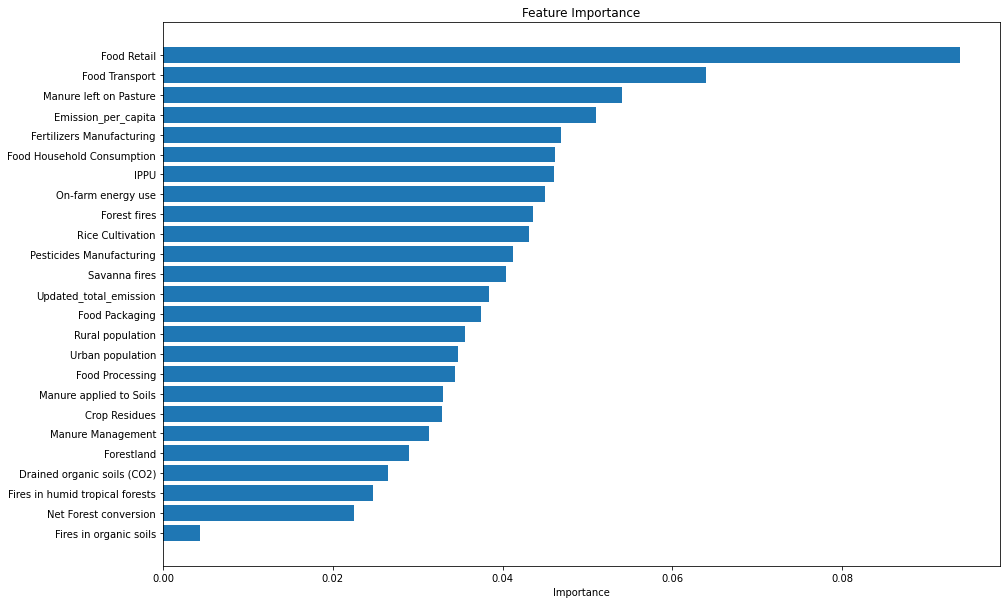

In [68]:
# Unzip the sorted features and importances
features, importance = zip(*sorted_features)

# Create a horizontal bar plot
plt.figure(figsize=(15, 10))
plt.barh(features, importance, align='center')

# Invert the y-axis for better readability
plt.gca().invert_yaxis()  
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()